### 設定資料集

In [ ]:
# global variable
SEED = 42
BATCH_SIZE = 128

In [ ]:
# global dataset settings
import os, math, random, time
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.manual_seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device info : ', device)

transform = transforms.Compose([
    transforms.ToTensor(),             # [0,1]
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

def show_grid(tensor, nrow=10, title=None):
    """
    在 Notebook 直接顯示多張影像圖格（不存檔）
    - tensor: [N, C, H, W]，建議在 [0,1]；這裡會 normalize=True 顯示
    - nrow:   每列要排多少張
    - title:  圖片上方的標題（可省略）
    """
    grid = utils.make_grid(tensor.detach().cpu(), nrow=nrow, padding=2, normalize=True)
    h = int(math.ceil(tensor.size(0) / nrow))
    plt.figure(figsize=(nrow*1.2, h*1.2))
    plt.imshow(grid.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# 存圖小工具
def save_grid(tensor, path, nrow=10):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    grid = utils.make_grid(tensor.detach().cpu(), nrow=nrow, padding=2, normalize=True)
    utils.save_image(grid, path)
    print("Saved:", path)

device info :  cuda


### VAE（Variational Autoencoder）
原理?

Ans : 像壓縮／解壓器。先把圖壓成一個「潛在向量 z」，再解回圖。

https://www.ibm.com/think/topics/variational-autoencoder

為什麼能生圖?

Ans : 訓練完成後，可以直接抽一個 z（高斯分佈）丟進 Decoder 生成新圖。

損失函數?

Ans : 重建型BCE（BCEWithLogitsLoss） + KLD（讓 z 長得像標準常態）。

In [ ]:
# ========== VAE：編碼器 / 解碼器 / 模型本體 ==========
LATENT = 30  # 潛在向量 z 的維度（資訊瓶頸大多在這裡調）

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 卷積編碼器：把 28x28 灰階圖一路壓到 7x7x64 的特徵
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # stride=2，空間 28->14，通道 1->32
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), # 再次下採樣 14->7，通道 32->64
            nn.ReLU(True),
            nn.Flatten(),               # 攤平成向量（64*7*7）
        )
        # 兩個全連接層：輸出每一維 z 的 μ 與 log σ^2（對角高斯）
        self.fc_mu = nn.Linear(64*7*7, LATENT)
        self.fc_logvar = nn.Linear(64*7*7, LATENT)

    def forward(self, x):
        h = self.net(x)            # 影像 → 壓縮特徵向量
        mu = self.fc_mu(h)         # 每張圖對應的潛在均值 μ
        logvar = self.fc_logvar(h) # 每張圖對應的潛在 log-variance（對應 σ^2）
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 先把潛在向量 z 提升回 7x7x64 的空間格
        self.fc = nn.Linear(LATENT, 64*7*7)
        # 反卷積（上採樣）一路還原到 28x28x1；最後一層不做激活，輸出 logits
        self.net = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 7->14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), # 14->28
            nn.ReLU(True),
            nn.Conv2d(16, 1, 3, 1, 1)            # 輸出 logits（搭配 BCEWithLogitsLoss）
        )

    def forward(self, z):
        h = self.fc(z).view(-1, 64, 7, 7)  # 全連接提維 → reshape 成特徵圖
        logits = self.net(h)               # 上採樣 → 影像 logits
        return logits

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder()  # qφ(z|x) 的參數化（輸出 μ、logσ^2）
        self.dec = Decoder()  # pθ(x|z) 的參數化（輸出影像 logits）

    def reparam(self, mu, logvar):
        """
        重參數化：z = μ + σ ⊙ ε，ε ~ N(0, I)
        好處：允許把「抽樣」寫成可微運算，梯度能傳回到 μ、logσ^2。
        """
        std = (0.5 * logvar).exp()     # σ = exp(0.5*logσ^2)
        eps = torch.randn_like(std)    # 取樣 ε
        return mu + eps * std          # reparameterization trick

    def forward(self, x):
        mu, logvar = self.enc(x)           # 先把 x 編成 μ、logσ^2
        z = self.reparam(mu, logvar)       # 依據 μ、σ 取樣 z
        logits = self.dec(z)               # 用 z 還原出影像 logits
        return logits, mu, logvar

def vae_loss(recon_logits, x, mu, logvar):
    """
    證據下界（ELBO）:
    我們真正想學的是後驗分佈 p(z∣x)（看到資料 x 後，潛變數 z 的機率長怎樣），p(x) 要把所有可能的 z 積分起來，超難算（對高維模型幾乎算不出來），於是 VAE 走「變分」路線：找一個好算的近似 qϕ
	  (z∣x)（編碼器輸出的高斯族），想辦法讓 qϕ 貼近 p(z∣x)。最直覺的做法是最小化KL(𝑞𝜙(𝑧∣𝑥) ∥ 𝑝(𝑧∣𝑥)),但這裡面也藏著 p(x) 所以沒法直接最小化。
    轉念：改成最大化 ELBO，受到 KL 散度損失項與重建損失項共同條件約束下，該自編碼器特定輸出與訓練資料「證據」相符合的程度。因此，訓練一個變分推斷模型也可以用最大化 ELBO 來描述。
    loss = BCE + KLD 就是 -ELBO，「loss 下降」⇔「ELBO 上升」（更接近真實對數似然的下界）所以
    ELBO等價最小化型式：重建 BCE + KL(q(z|x) || N(0,1))
    - recon_logits：Decoder 輸出 logits，故使用 BCEWithLogitsLoss 更穩
    - x：目標影像，範圍 [0,1]
    - mu, logvar：編碼器輸出的潛在分佈參數
    """
    # 重建項：對每個像素做 BCE, 衡量原始輸入資料與解碼器輸出(重建)之間的差異，reduction='sum' 再除以 batch，等同 per-sample sum
    bce = F.binary_cross_entropy_with_logits(recon_logits, x, reduction='sum')/x.size(0)

    # KL 正則項：迫使潛在變數的學習編碼服從高斯分布(標準常態分佈), 對角高斯相對 N(0,1) 的封閉解，對每個 sample sum，最後除 batch
    # KL = -1/2 * sum(1 + logσ^2 - μ^2 - σ^2)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())/x.size(0)

    return bce + kld, bce, kld

# ========== 建模與最佳化器 ==========
vae = VAE().to(device)                                  # 把模型丟到 CPU/GPU
opt_vae = torch.optim.Adam(vae.parameters(), lr=1e-3)   # 作業建議：VAE 用 1e-3

# ========== 訓練 ==========
EPOCHS_VAE = 30
for epoch in range(1, EPOCHS_VAE+1):
    vae.train()
    loss_sum, b_sum, k_sum = 0, 0, 0  # 累計總損失、BCE、KLD（看學習動態）
    for x, _ in tqdm(train_loader, desc=f"VAE Epoch {epoch}", leave=False):
        x = x.to(device)                                 # 影像丟到裝置
        recon_logits, mu, logvar = vae(x)                # 前向：得到重建 logits 與潛在分佈參數
        loss, bce, kld = vae_loss(recon_logits, x, mu, logvar)  # 算 ELBO 對應的 loss
        opt_vae.zero_grad()                              # 先把梯度清乾淨
        loss.backward()                                  # 反向傳播（自動微分）
        opt_vae.step()                                   # 依梯度更新參數
        loss_sum += loss.item()
        b_sum += bce.item()
        k_sum += kld.item()
    print(f"[VAE] epoch {epoch:02d} | loss={loss_sum/len(train_loader):.3f} | "
          f"BCEWithLogitsLoss(reconstruction loss)={b_sum/len(train_loader):.3f} | kL Divergence={k_sum/len(train_loader):.3f}")

VAE Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 01 | loss=162.329 | BCEWithLogitsLoss(reconstruction loss)=141.979 | kL Divergence=20.349


VAE Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 02 | loss=110.991 | BCEWithLogitsLoss(reconstruction loss)=83.244 | kL Divergence=27.748


VAE Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 03 | loss=107.198 | BCEWithLogitsLoss(reconstruction loss)=79.256 | kL Divergence=27.942


VAE Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 04 | loss=105.491 | BCEWithLogitsLoss(reconstruction loss)=77.689 | kL Divergence=27.802


VAE Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 05 | loss=104.470 | BCEWithLogitsLoss(reconstruction loss)=76.806 | kL Divergence=27.664


VAE Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 06 | loss=103.700 | BCEWithLogitsLoss(reconstruction loss)=76.156 | kL Divergence=27.545


VAE Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 07 | loss=103.094 | BCEWithLogitsLoss(reconstruction loss)=75.685 | kL Divergence=27.409


VAE Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 08 | loss=102.593 | BCEWithLogitsLoss(reconstruction loss)=75.304 | kL Divergence=27.289


VAE Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 09 | loss=102.162 | BCEWithLogitsLoss(reconstruction loss)=74.967 | kL Divergence=27.195


VAE Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 10 | loss=101.796 | BCEWithLogitsLoss(reconstruction loss)=74.692 | kL Divergence=27.104


VAE Epoch 11:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 11 | loss=101.506 | BCEWithLogitsLoss(reconstruction loss)=74.482 | kL Divergence=27.024


VAE Epoch 12:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 12 | loss=101.217 | BCEWithLogitsLoss(reconstruction loss)=74.295 | kL Divergence=26.922


VAE Epoch 13:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 13 | loss=100.956 | BCEWithLogitsLoss(reconstruction loss)=74.087 | kL Divergence=26.869


VAE Epoch 14:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 14 | loss=100.664 | BCEWithLogitsLoss(reconstruction loss)=73.891 | kL Divergence=26.773


VAE Epoch 15:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 15 | loss=100.414 | BCEWithLogitsLoss(reconstruction loss)=73.747 | kL Divergence=26.667


VAE Epoch 16:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 16 | loss=100.246 | BCEWithLogitsLoss(reconstruction loss)=73.646 | kL Divergence=26.600


VAE Epoch 17:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 17 | loss=100.015 | BCEWithLogitsLoss(reconstruction loss)=73.498 | kL Divergence=26.517


VAE Epoch 18:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 18 | loss=99.833 | BCEWithLogitsLoss(reconstruction loss)=73.364 | kL Divergence=26.469


VAE Epoch 19:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 19 | loss=99.650 | BCEWithLogitsLoss(reconstruction loss)=73.249 | kL Divergence=26.401


VAE Epoch 20:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 20 | loss=99.458 | BCEWithLogitsLoss(reconstruction loss)=73.119 | kL Divergence=26.339


VAE Epoch 21:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 21 | loss=99.301 | BCEWithLogitsLoss(reconstruction loss)=73.042 | kL Divergence=26.258


VAE Epoch 22:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 22 | loss=99.194 | BCEWithLogitsLoss(reconstruction loss)=72.965 | kL Divergence=26.229


VAE Epoch 23:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 23 | loss=99.034 | BCEWithLogitsLoss(reconstruction loss)=72.892 | kL Divergence=26.142


VAE Epoch 24:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 24 | loss=98.886 | BCEWithLogitsLoss(reconstruction loss)=72.800 | kL Divergence=26.086


VAE Epoch 25:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 25 | loss=98.762 | BCEWithLogitsLoss(reconstruction loss)=72.694 | kL Divergence=26.068


VAE Epoch 26:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 26 | loss=98.661 | BCEWithLogitsLoss(reconstruction loss)=72.664 | kL Divergence=25.998


VAE Epoch 27:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 27 | loss=98.567 | BCEWithLogitsLoss(reconstruction loss)=72.606 | kL Divergence=25.962


VAE Epoch 28:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 28 | loss=98.427 | BCEWithLogitsLoss(reconstruction loss)=72.520 | kL Divergence=25.907


VAE Epoch 29:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 29 | loss=98.350 | BCEWithLogitsLoss(reconstruction loss)=72.480 | kL Divergence=25.869


VAE Epoch 30:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 30 | loss=98.195 | BCEWithLogitsLoss(reconstruction loss)=72.389 | kL Divergence=25.806


[Recon] 平均重建 BCE（越小越好）: 0.0893


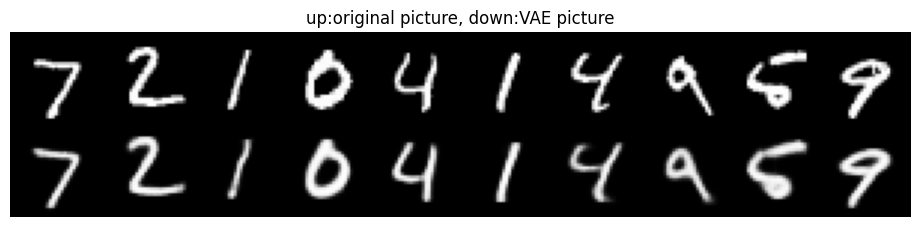

In [ ]:
# 原圖 vs 重建：上排原圖、下排重建（只顯示，不存檔）
vae.eval()
with torch.no_grad():
    # 取一個 batch（優先用 test_loader；沒有就用 train_loader）
    try:
        batch = next(iter(test_loader))
    except NameError:
        batch = next(iter(train_loader))

    x_batch, _ = batch
    x_batch = x_batch.to(device)
    bs = x_batch.size(0)
    num_show = min(10, bs)  # 顯示前 10 張

    # 前向重建
    recon_logits, mu, logvar = vae(x_batch)
    x_recon = torch.sigmoid(recon_logits)

    # 簡單的重建品質數字：每張圖的 BCE（參考用）
    import torch.nn.functional as F
    bce_per_img = F.binary_cross_entropy_with_logits(
        recon_logits, x_batch, reduction='none'
    ).view(bs, -1).mean(dim=1)
    print(f"[Recon] 平均重建 BCE（越小越好）: {bce_per_img.mean().item():.4f}")

    # 2xN 的對照：上=原圖，下=重建
    top = x_batch[:num_show].detach().cpu()
    bottom = x_recon[:num_show].detach().cpu()
    compare_grid = torch.cat([top, bottom], dim=0)  # [2N, 1, 28, 28]
    show_grid(compare_grid, nrow=num_show, title="up:original picture, down:VAE picture")

### GAN (Generative Adversarial Network)
原理?

Ans : Generator 造假圖；Discriminator 抓哪裡假。互相逼到位，假圖就越像真的。

為什麼能生圖?

Ans : 訓練完成後，拿隨機噪聲 z → G → 圖

損失函數?

Ans : 對抗 BCE（BCEWithLogitsLoss）

In [ ]:
NZ = 100  # 噪聲 z 的維度（生成器輸入）；越大潛在空間越豐富，但也更難學

class G(nn.Module):
    def __init__(self):
        super().__init__()
        # 先用一層全連接把 z 投影到 7x7x256 的「小特徵圖」作為起點
        self.fc = nn.Linear(NZ, 256*7*7)
        # 反卷積堆疊：逐步上採樣到 28x28x1（MNIST）
        self.net = nn.Sequential(
            nn.BatchNorm2d(256),                   # 生成器常用 BN 穩定訓練與放大梯度
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 7->14 上採樣
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 14->28 上採樣
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 1, 3, 1, 1)              # 輸出 logits；稍後經 Sigmoid 到 [0,1]
        )
    def forward(self, z):
        # z: [B, NZ]
        h = self.fc(z).view(-1, 256, 7, 7)         # [B, 256, 7, 7]
        logits = self.net(h)                        # [B, 1, 28, 28]
        x = torch.sigmoid(logits)                   # 映到 [0,1]，與真實影像尺度一致
        return x

class D(nn.Module):
    def __init__(self):
        super().__init__()
        # 判別器：輸入 28x28x1，輸出一個 logit（越大越像真）
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),              # 28->14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),            # 14->7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1)                   # 單一 logit；BCEWithLogitsLoss 直接吃
        )
    def forward(self, x):
        # x: [B, 1, 28, 28]
        return self.net(x).view(-1)                 # [B]，每個是 logit

G_gan = G().to(device)
D_gan = D().to(device)

# 兩個優化器分開；DCGAN 經典設定 betas=(0.5, 0.999) 幫助穩定
opt_G = torch.optim.Adam(G_gan.parameters(), lr=1e-4, betas=(0.5, 0.999))  # TTUR: G 小一點
opt_D = torch.optim.Adam(D_gan.parameters(), lr=4e-4, betas=(0.5, 0.999))  # TTUR: D 大一點
bce = nn.BCEWithLogitsLoss()  # 注意：這個 loss 期望輸入是「logits」，不是 sigmoid 後機率

# ==== 訓練循環（逐步中文註解） ================================================
from tqdm.auto import tqdm

EPOCHS_GAN = 60

for epoch in range(1, EPOCHS_GAN+1):
    D_loss_sum = G_loss_sum = 0.0
    for x_real, _ in tqdm(train_loader, desc=f"GAN Epoch {epoch}", leave=False):
        x_real = x_real.to(device)       # 真實影像（[0,1]）
        bs = x_real.size(0)

        # -------- 1) 先訓練 Discriminator（讓 D 更會分辨） --------
        # 生成假圖（detach 切斷 G 的梯度，避免 D 的更新回流到 G）
        z = torch.randn(bs, NZ, device=device)
        x_fake = G_gan(z).detach()
        # D 分別看真與假，輸出 logits
        logits_real = D_gan(x_real)
        logits_fake = D_gan(x_fake)
        # 真實標籤做「label smoothing」：將 1 改為 U[0.8,1.0]，降低 D 的過度自信，提升穩定性
        real_targets = torch.empty(bs, device=device).uniform_(0.8, 1.0)
        fake_targets = torch.zeros(bs, device=device)  # 假樣本標籤 = 0
        # D 的 loss = 真樣本判真 + 假樣本判假
        loss_D = bce(logits_real, real_targets) + bce(logits_fake, fake_targets)
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # -------- 2) 再訓練 Generator（讓 G 更會騙過 D） --------
        # 重新取噪聲（或不重取也行），這次不 detach，讓梯度回到 G
        z = torch.randn(bs, NZ, device=device)
        x_fake = G_gan(z)
        logits_fake = D_gan(x_fake)
        # 對 G 來說，它希望「D 認為假的也是真的」→ 標籤=1
        real_targets_for_G = torch.ones(bs, device=device)
        loss_G = bce(logits_fake, real_targets_for_G)
        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        D_loss_sum += loss_D.item()
        G_loss_sum += loss_G.item()

    print(f"[GAN] epoch {epoch:02d} | D={D_loss_sum/len(train_loader):.3f} | G={G_loss_sum/len(train_loader):.3f}")

GAN Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 01 | D=0.647 | G=2.730


GAN Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 02 | D=0.655 | G=2.272


GAN Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 03 | D=0.813 | G=1.870


GAN Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 04 | D=0.816 | G=1.855


GAN Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 05 | D=0.812 | G=1.885


GAN Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 06 | D=0.828 | G=1.891


GAN Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 07 | D=0.814 | G=1.920


GAN Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 08 | D=0.814 | G=1.947


GAN Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 09 | D=0.824 | G=1.950


GAN Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 10 | D=0.802 | G=1.993


GAN Epoch 11:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 11 | D=0.812 | G=2.026


GAN Epoch 12:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 12 | D=0.820 | G=2.014


GAN Epoch 13:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 13 | D=0.806 | G=2.028


GAN Epoch 14:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 14 | D=0.823 | G=2.027


GAN Epoch 15:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 15 | D=0.812 | G=2.042


GAN Epoch 16:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 16 | D=0.811 | G=2.048


GAN Epoch 17:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 17 | D=0.832 | G=2.038


GAN Epoch 18:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 18 | D=0.809 | G=2.055


GAN Epoch 19:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 19 | D=0.825 | G=2.058


GAN Epoch 20:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 20 | D=0.826 | G=2.045


GAN Epoch 21:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 21 | D=0.827 | G=2.034


GAN Epoch 22:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 22 | D=0.835 | G=2.028


GAN Epoch 23:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 23 | D=0.840 | G=2.047


GAN Epoch 24:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 24 | D=0.836 | G=2.016


GAN Epoch 25:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 25 | D=0.842 | G=2.028


GAN Epoch 26:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 26 | D=0.849 | G=2.011


GAN Epoch 27:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 27 | D=0.847 | G=2.004


GAN Epoch 28:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 28 | D=0.849 | G=2.001


GAN Epoch 29:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 29 | D=0.857 | G=2.003


GAN Epoch 30:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 30 | D=0.856 | G=1.990


GAN Epoch 31:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 31 | D=0.849 | G=1.979


GAN Epoch 32:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 32 | D=0.863 | G=1.981


GAN Epoch 33:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 33 | D=0.864 | G=1.990


GAN Epoch 34:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 34 | D=0.867 | G=1.970


GAN Epoch 35:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 35 | D=0.863 | G=1.977


GAN Epoch 36:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 36 | D=0.868 | G=1.953


GAN Epoch 37:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 37 | D=0.869 | G=1.978


GAN Epoch 38:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 38 | D=0.871 | G=1.962


GAN Epoch 39:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 39 | D=0.867 | G=1.974


GAN Epoch 40:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 40 | D=0.875 | G=1.963


GAN Epoch 41:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 41 | D=0.876 | G=1.946


GAN Epoch 42:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 42 | D=0.868 | G=1.965


GAN Epoch 43:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 43 | D=0.877 | G=1.979


GAN Epoch 44:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 44 | D=0.868 | G=1.964


GAN Epoch 45:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 45 | D=0.885 | G=1.975


GAN Epoch 46:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 46 | D=0.877 | G=1.955


GAN Epoch 47:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 47 | D=0.878 | G=1.958


GAN Epoch 48:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 48 | D=0.889 | G=1.946


GAN Epoch 49:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 49 | D=0.871 | G=1.962


GAN Epoch 50:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 50 | D=0.882 | G=1.957


GAN Epoch 51:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 51 | D=0.889 | G=1.951


GAN Epoch 52:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 52 | D=0.879 | G=1.949


GAN Epoch 53:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 53 | D=0.885 | G=1.945


GAN Epoch 54:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 54 | D=0.876 | G=1.942


GAN Epoch 55:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 55 | D=0.886 | G=1.948


GAN Epoch 56:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 56 | D=0.887 | G=1.954


GAN Epoch 57:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 57 | D=0.874 | G=1.940


GAN Epoch 58:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 58 | D=0.883 | G=1.952


GAN Epoch 59:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 59 | D=0.880 | G=1.949


GAN Epoch 60:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 60 | D=0.881 | G=1.959


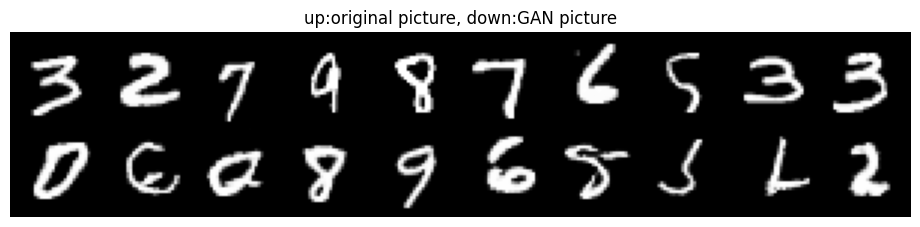

In [ ]:
# ==== 顯示：真實圖 vs 生成圖 對照（上排真實 / 下排生成） ==========================
G_gan.eval()
with torch.no_grad():
    # 取一個 batch 當作真實對照
    real_batch, _ = next(iter(train_loader))
    real_batch = real_batch.to(device)
    num_show = min(10, real_batch.size(0))  # 顯示前 10 張

    # 生成同數量的假圖
    z = torch.randn(num_show, NZ, device=device)
    fake_batch = G_gan(z)

    # 組成 2×N 的圖：上=真實，下=生成
    top = real_batch[:num_show].detach().cpu()
    bottom = fake_batch[:num_show].detach().cpu()
    compare = torch.cat([top, bottom], dim=0)  # [2N,1,28,28]
    show_grid(compare, nrow=num_show, title="up:original picture, down:GAN picture")

### cGAN（Conditional GAN）
原理?

Ans : 在 GAN 上加「條件」。你告訴它「我想要 7」，它才會生 7。

為什麼能生圖?

Ans : 把 label（one-hot）跟噪聲一起丟給 G；D 也看圖＋label。

損失函數?

Ans : 對抗 BCE（BCEWithLogitsLoss）

In [ ]:
# 條件 GAN（cGAN）：在 G/D 都餵入類別 y 作為條件
NZ = 100        # 噪聲 z 的維度（生成器輸入）
NUM_CLASSES = 10
EMB = 16        # 類別嵌入向量的維度（越大越靈活，但也更難學）

class CG_G(nn.Module):
    """
    生成器 G(z, y)：把「噪聲 z + 類別嵌入 e(y)」拼接後，逐步上採樣到 28×28×1。
    最後輸出 logits 經 Sigmoid 到 [0,1]，與 MNIST 真實影像尺度一致。
    """
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(NUM_CLASSES, EMB)       # 把整數標籤 y 映到 EMB 維的連續向量
        self.fc = nn.Linear(NZ + EMB, 256*7*7)            # 先投影到 7×7×256 小特徵圖
        self.net = nn.Sequential(
            nn.BatchNorm2d(256),                          # 生成器常用 BN 幫助穩定
            nn.ConvTranspose2d(256, 128, 4, 2, 1),        # 7->14 上採樣
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),         # 14->28 上採樣
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 1, 3, 1, 1)                     # 輸出 logits；稍後走 Sigmoid
        )
    def forward(self, z, y):
        e = self.embed(y)                                  # e(y): [B, EMB]
        h = self.fc(torch.cat([z, e], dim=1)).view(-1, 256, 7, 7)
        logits = self.net(h)
        return torch.sigmoid(logits)                       # 映到 [0,1]

class CG_D(nn.Module):
    """
    判別器 D(x, y)：把類別 y 畫成 28×28 的「條件圖」，與影像在 channel 維度拼接，輸出真實性的 logit。
    """
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(NUM_CLASSES, 28*28)      # 將 y 畫成一張 28×28 的「條件圖」
        self.conv = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1),                     # 輸入通道=2（影像1 + 條件1），28->14
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1),                   # 14->7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1)                          # 輸出單一 logit（越大越像真）
        )
    def forward(self, x, y):
        ymap = self.embed(y).view(-1, 1, 28, 28)           # 把 y 畫成 [B,1,28,28]
        x_in = torch.cat([x, ymap], dim=1)                 # [B,2,28,28]
        return self.conv(x_in).view(-1)                    # [B]

G_cgan = CG_G().to(device)
D_cgan = CG_D().to(device)

opt_Gc = torch.optim.Adam(G_cgan.parameters(), lr=2e-4, betas=(0.5, 0.999))  # DCGAN 經典設定
opt_Dc = torch.optim.Adam(D_cgan.parameters(), lr=2e-4, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()        # 注意：這個 loss 直接吃「logits」，不用手動 sigmoid

EPOCHS_CGAN = 30

for epoch in range(1, EPOCHS_CGAN+1):
    D_loss_sum = G_loss_sum = 0.0
    for x_real, y in tqdm(train_loader, desc=f"cGAN Epoch {epoch}", leave=False):
        x_real, y = x_real.to(device), y.to(device)
        bs = x_real.size(0)

        # ---- 1) 先更新 D（讓判別器更會分辨） ----
        # 生成條件假圖（detach 切斷對 G 的梯度）
        z = torch.randn(bs, NZ, device=device)
        x_fake = G_cgan(z, y).detach()

        # D 對真實/生成 各出一個 logit
        logits_real = D_cgan(x_real, y)
        logits_fake = D_cgan(x_fake, y)

        # Label smoothing：真實標籤 U[0.8,1.0]，降低 D 的過度自信，使對抗更穩
        real_targets = torch.empty(bs, device=device).uniform_(0.8, 1.0)
        fake_targets = torch.zeros(bs, device=device)

        # D 的 loss = 真樣本判真 + 假樣本判假
        loss_D = bce(logits_real, real_targets) + bce(logits_fake, fake_targets)
        opt_Dc.zero_grad()
        loss_D.backward()
        opt_Dc.step()

        # ---- 2) 再更新 G（讓生成器更會騙過 D） ----
        z = torch.randn(bs, NZ, device=device)
        x_fake = G_cgan(z, y)                   # 這次不 detach，梯度回到 G
        logits_fake = D_cgan(x_fake, y)

        # 對 G 來說，希望 D 把假圖當真 ⇒ 標籤=1
        loss_G = bce(logits_fake, torch.ones(bs, device=device))
        opt_Gc.zero_grad()
        loss_G.backward()
        opt_Gc.step()

        D_loss_sum += loss_D.item()
        G_loss_sum += loss_G.item()

    print(f"[cGAN] epoch {epoch:02d} | D={D_loss_sum/len(train_loader):.3f} | G={G_loss_sum/len(train_loader):.3f}")

cGAN Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 01 | D=1.184 | G=1.093


cGAN Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 02 | D=1.209 | G=1.068


cGAN Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 03 | D=1.295 | G=0.969


cGAN Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 04 | D=1.340 | G=0.897


cGAN Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 05 | D=1.352 | G=0.874


cGAN Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 06 | D=1.361 | G=0.865


cGAN Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 07 | D=1.366 | G=0.858


cGAN Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 08 | D=1.369 | G=0.853


cGAN Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 09 | D=1.373 | G=0.845


cGAN Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 10 | D=1.376 | G=0.848


cGAN Epoch 11:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 11 | D=1.376 | G=0.845


cGAN Epoch 12:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 12 | D=1.378 | G=0.838


cGAN Epoch 13:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 13 | D=1.377 | G=0.841


cGAN Epoch 14:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 14 | D=1.379 | G=0.834


cGAN Epoch 15:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 15 | D=1.379 | G=0.834


cGAN Epoch 16:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 16 | D=1.378 | G=0.829


cGAN Epoch 17:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 17 | D=1.379 | G=0.832


cGAN Epoch 18:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 18 | D=1.380 | G=0.830


cGAN Epoch 19:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 19 | D=1.380 | G=0.829


cGAN Epoch 20:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 20 | D=1.379 | G=0.825


cGAN Epoch 21:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 21 | D=1.380 | G=0.825


cGAN Epoch 22:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 22 | D=1.380 | G=0.827


cGAN Epoch 23:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 23 | D=1.380 | G=0.825


cGAN Epoch 24:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 24 | D=1.380 | G=0.825


cGAN Epoch 25:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 25 | D=1.380 | G=0.822


cGAN Epoch 26:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 26 | D=1.380 | G=0.825


cGAN Epoch 27:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 27 | D=1.379 | G=0.822


cGAN Epoch 28:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 28 | D=1.379 | G=0.821


cGAN Epoch 29:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 29 | D=1.379 | G=0.821


cGAN Epoch 30:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 30 | D=1.379 | G=0.822


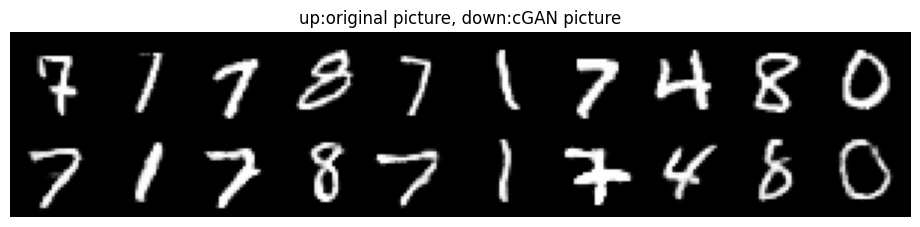

In [ ]:
# 從資料抓一個小批次，讓生成器用「相同的 y」生成對照
G_cgan.eval()
with torch.no_grad():
    real_batch, y_batch = next(iter(train_loader))          # 取一批真實圖與其標籤
    real_batch = real_batch.to(device)
    y_batch = y_batch.to(device)
    num_show = min(10, real_batch.size(0))                  # 顯示前 10 張

    z = torch.randn(num_show, NZ, device=device)
    fake_batch = G_cgan(z, y_batch[:num_show])              # 用相同的 y 生成

    # 組 2×N 圖：上=真實、下=生成（同一欄是同一個標籤）
    top = real_batch[:num_show].detach().cpu()
    bottom = fake_batch[:num_show].detach().cpu()
    compare = torch.cat([top, bottom], dim=0)               # [2N,1,28,28]
    show_grid(compare, nrow=num_show, title="up:original picture, down:cGAN picture")

### Diffusion（DDPM 類）
原理?

Ans : 先把真圖逐步加噪到全是雜訊（forward）；訓一個模型學會「每一步怎麼去噪」（reverse）。

為什麼能生圖?

Ans : 從純噪聲開始，按步驟慢慢去噪，最後得到清楚的圖。

損失函數?

Ans : 預測噪聲的 MSE；常用於小型 U-Net。

In [ ]:
# ===== 時間嵌入：把離散時間步 t 映成連續向量，用於調制每個殘差塊 =====
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim  # 輸出向量維度（偶數）

    def forward(self, t):
        # t: [B] 或 [B,]，通常是 0..T-1 的整數（也可轉 float）
        device = t.device
        half = self.dim // 2                      # 一半維度給 sin，一半給 cos
        freq_step = math.log(10000) / (half - 1)  # 頻率間距
        freqs = torch.exp(torch.arange(half, device=device) * -freq_step)  # [half]
        # 外積：每個 batch 的 t 擴展乘上不同頻率
        angles = t[:, None] * freqs[None, :]      # [B, half]
        emb = torch.cat([angles.sin(), angles.cos()], dim=1)  # [B, dim]
        return emb

# ===== 殘差塊：輸入 + 時間調制，GroupNorm + SiLU，比較穩 =====
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )
        # 時間向量用 MLP 映到通道維度，作為調制偏置加進特徵
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_dim, out_ch)
        )
        # 若通道數變了，走 1x1 殘差對齊；否則 Identity
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        t = self.time_mlp(t_emb)[:, :, None, None]  # [B, out_ch, 1, 1]
        h = h + t                                   # 時間調制
        h = self.block2(h)
        return h + self.res_conv(x)                 # 殘差連接

# ===== 小 U-Net：下採樣→中間層→上採樣；每層都吃時間調制 =====
class SmallUNet(nn.Module):
    def __init__(self, t_dim=64):
        super().__init__()
        # 先用正弦位置嵌入把 t 轉成向量，再經過一個小 MLP
        self.tok = SinusoidalPosEmb(t_dim//2)
        self.time_mlp = nn.Sequential(nn.Linear(t_dim, t_dim), nn.SiLU())

        # Encoder/down
        self.down1 = ResidualBlock(1, 32, t_dim)   # 1->32 通道
        self.down2 = ResidualBlock(32, 64, t_dim)  # 32->64
        self.pool = nn.AvgPool2d(2)                # 簡單下採樣（28->14）

        # Mid
        self.mid = ResidualBlock(64, 64, t_dim)

        # Decoder/up
        self.up1 = ResidualBlock(64, 32, t_dim)    # 64->32
        self.up2 = ResidualBlock(32, 16, t_dim)    # 32->16
        self.final = nn.Conv2d(16, 1, 1)           # 輸出 1 通道（預測噪聲 ε̂）

    def forward(self, x, t):
        # t 可能是 int；這裡把它送進位置嵌入後，接 MLP
        t_emb = self.tok(t)                         # [B, t_dim//2]
        t_emb = torch.cat([t_emb, t_emb], dim=1)    # 拼接成 [B, t_dim]（偷懶讓維度對齊）
        t_emb = self.time_mlp(t_emb)                # [B, t_dim]

        # Encoder
        h1 = self.down1(x, t_emb)                   # [B,32,28,28]
        h2 = self.pool(h1)                          # [B,32,14,14]
        h2 = self.down2(h2, t_emb)                  # [B,64,14,14]

        # Mid
        h3 = self.mid(h2, t_emb)                    # [B,64,14,14]

        # Decoder（這裡沒有 U-Net 的 skip 接，但足夠跑 MNIST）
        h4 = F.interpolate(h3, scale_factor=2, mode='nearest')  # 14->28
        h4 = self.up1(h4, t_emb)                    # [B,32,28,28]
        h5 = self.up2(h4, t_emb)                    # [B,16,28,28]
        out = self.final(h5)                        # [B,1,28,28]，預測噪聲 ε̂
        return out

# ===== 噪聲步數（T 越大越穩但越慢；示範用 200）=====
T = 200
beta = torch.linspace(1e-4, 0.02, T, device=device)  # 線性 beta schedule（簡單好用）
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)              # 積累乘積：\bar{α}_t = ∏_{s≤t} α_s

# ===== 前向擾動 q(x_t|x_0)：一次公式把 x_0 加噪到 x_t =====
def q_sample(x0, t, noise=None):
    """
    x0: 乾淨圖 [B,1,28,28]
    t:  每張圖對應的步數 [B] (0..T-1)
    回傳：x_t = sqrt(\bar{α}_t) * x0 + sqrt(1-\bar{α}_t) * ε
    """
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_ab = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_one_minus_ab = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    return sqrt_ab * x0 + sqrt_one_minus_ab * noise

# ===== 訓練損失：隨機抽 t，讓模型學會預測噪聲 ε =====
def p_losses(model, x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)         # 把 x0 加噪到 x_t
    pred_noise = model(xt, t.float())   # 預測 ε̂(xt, t)
    return F.mse_loss(pred_noise, noise)  # MSE(ε̂, ε)

model = SmallUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-4)

EPOCHS_DDPM = 30  # 先 smoke test；要畫質更好就拉長 epochs 或加大 T
from tqdm.auto import tqdm

for epoch in range(1, EPOCHS_DDPM+1):
    loss_sum = 0.0
    for x, _ in tqdm(train_loader, desc=f"DDPM Epoch {epoch}", leave=False):
        x = x.to(device)                                 # 真實乾淨圖（[0,1]）
        bs = x.size(0)
        t = torch.randint(0, T, (bs,), device=device).long()  # 每張圖抽一個步數
        loss = p_losses(model, x, t)                     # 預測噪聲的 MSE
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_sum += loss.item()
    print(f"[DDPM] epoch {epoch:02d} | loss={loss_sum/len(train_loader):.4f}")

# ===== 從 x_T ~ N(0,I) 逐步去噪到 x_0 =====
@torch.no_grad()
def p_sample(model, xt, t):
    # 這三個都是「標量 tensor」
    beta_t = beta[t]
    sqrt_one_minus_ab_t = torch.sqrt(1 - alpha_bar[t])
    sqrt_recip_alpha_t = torch.sqrt(1.0 / alpha[t])

    # 給模型的 t 要有 batch 維度，這裡做成 [B]
    t_batch = torch.full((xt.size(0),), float(t), device=xt.device)

    # 預測噪聲 ε̂(xt, t)
    eps_theta = model(xt, t_batch)

    # 標量自動廣播到 xt 的形狀，無需 [:, None, None, None]
    mean = sqrt_recip_alpha_t * (xt - (beta_t / sqrt_one_minus_ab_t) * eps_theta)

    if t > 0:
        z = torch.randn_like(xt)
        sigma_t = torch.sqrt(beta_t)
        sample = mean + sigma_t * z    # 同樣用標量廣播
    else:
        sample = mean
    return sample


@torch.no_grad()
def sample(model, n=10):
    """
    從純噪聲開始，跑 T..1..0 的去噪步驟，得到生成影像
    """
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)          # x_T
    for t in reversed(range(T)):
        x = p_sample(model, x, t)
    x = torch.clamp(x, 0.0, 1.0)                          # 約束到 [0,1] 方便顯示
    return x

DDPM Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 01 | loss=0.2867


DDPM Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 02 | loss=0.1196


DDPM Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 03 | loss=0.0964


DDPM Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 04 | loss=0.0843


DDPM Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 05 | loss=0.0769


DDPM Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 06 | loss=0.0720


DDPM Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 07 | loss=0.0679


DDPM Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 08 | loss=0.0649


DDPM Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 09 | loss=0.0624


DDPM Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 10 | loss=0.0610


DDPM Epoch 11:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 11 | loss=0.0590


DDPM Epoch 12:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 12 | loss=0.0573


DDPM Epoch 13:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 13 | loss=0.0559


DDPM Epoch 14:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 14 | loss=0.0548


DDPM Epoch 15:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 15 | loss=0.0536


DDPM Epoch 16:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 16 | loss=0.0530


DDPM Epoch 17:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 17 | loss=0.0521


DDPM Epoch 18:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 18 | loss=0.0514


DDPM Epoch 19:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 19 | loss=0.0507


DDPM Epoch 20:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 20 | loss=0.0501


DDPM Epoch 21:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 21 | loss=0.0491


DDPM Epoch 22:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 22 | loss=0.0488


DDPM Epoch 23:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 23 | loss=0.0478


DDPM Epoch 24:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 24 | loss=0.0481


DDPM Epoch 25:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 25 | loss=0.0474


DDPM Epoch 26:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 26 | loss=0.0472


DDPM Epoch 27:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 27 | loss=0.0467


DDPM Epoch 28:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 28 | loss=0.0462


DDPM Epoch 29:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 29 | loss=0.0457


DDPM Epoch 30:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 30 | loss=0.0454


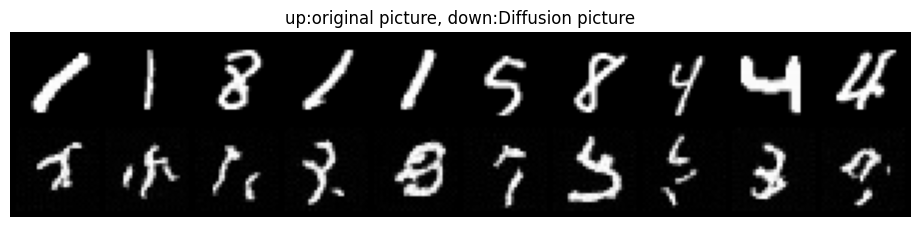

In [ ]:
with torch.no_grad():
    real_batch, _ = next(iter(train_loader))              # 取一批真實 MNIST
    real_batch = real_batch.to(device)
    num_show = min(10, real_batch.size(0))

    fake_batch = sample(model, n=num_show)

    top = real_batch[:num_show].detach().cpu()
    bottom = fake_batch[:num_show].detach().cpu()
    compare = torch.cat([top, bottom], dim=0)             # [2N,1,28,28]
    show_grid(compare, nrow=num_show, title="up:original picture, down:Diffusion picture")

### 4種效果比較

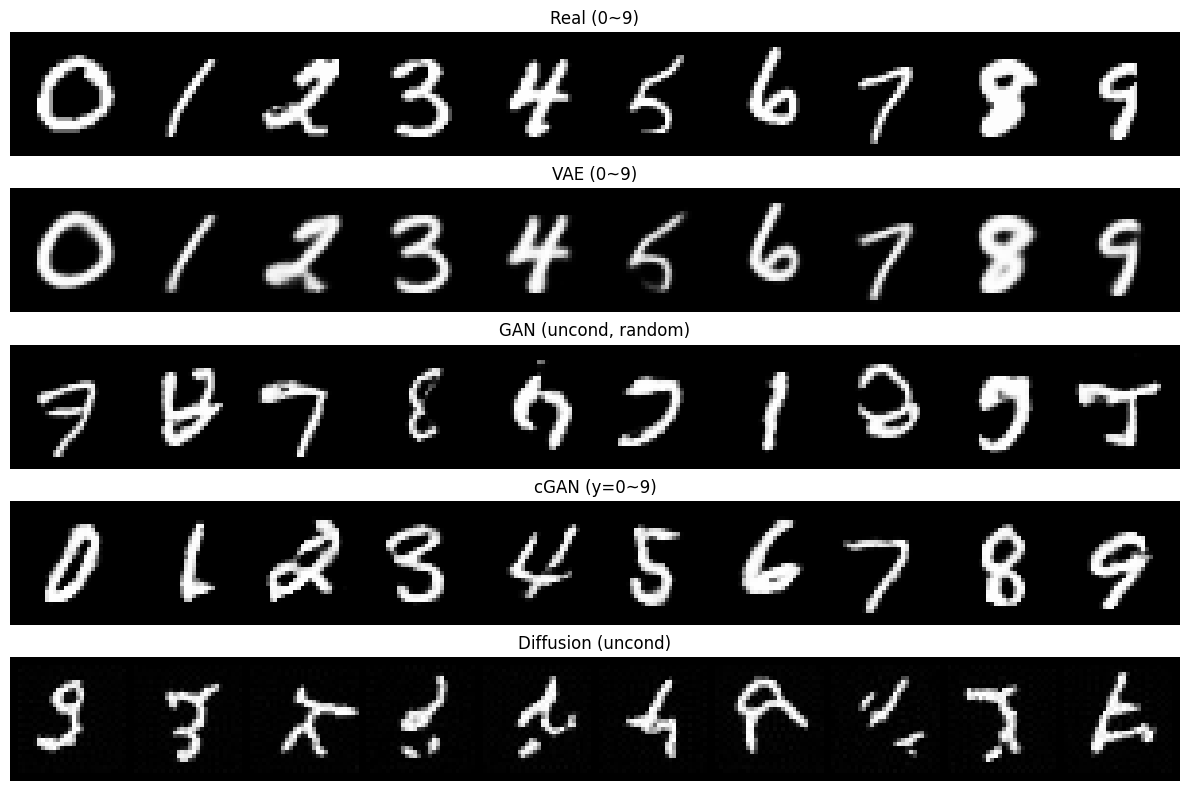

In [22]:
@torch.no_grad()
def get_real_0to9(loader):
    """從資料集中各取 1 張『0..9』，回傳 shape=[10,1,28,28]（依 0..9 排序）。"""
    buckets = {i: None for i in range(10)}
    for xb, yb in loader:
        for i in range(xb.size(0)):
            c = int(yb[i])
            if buckets[c] is None:
                buckets[c] = xb[i:i+1]  # [1,1,28,28]
        if all(v is not None for v in buckets.values()):
            break
    rows = [buckets[c] for c in range(10)]
    return torch.cat(rows, dim=0)  # [10,1,28,28]

@torch.no_grad()
def collect_panel_0to9():
    rows, titles = [], []

    # (0) Real：原始 0..9
    real_0to9 = get_real_0to9(train_loader)                 # CPU
    rows.append(real_0to9); titles.append("Real (0~9)")

    # (1) VAE：對同一批 0..9 做『重建』，確保列出來也是 0..9
    if 'vae' in globals():
        x = real_0to9.to(device)
        mu, logvar = vae.enc(x)                             # 取編碼器輸出
        recon_logits = vae.dec(mu)                          # 用均值重建（更穩定）
        vae_recon = torch.sigmoid(recon_logits).cpu()       # [0,1]
        rows.append(vae_recon); titles.append("VAE (0~9)")

    # (2) GAN（無條件）：只能隨機 10 張，無法指定數字（仍保留一列做比較）
    if 'G_gan' in globals():
        z = torch.randn(10, NZ, device=device)
        gan_samples = G_gan(z).cpu()
        rows.append(gan_samples); titles.append("GAN (uncond, random)")

    # (3) cGAN：直接指定 y=0..9
    if 'G_cgan' in globals():
        z = torch.randn(10, NZ, device=device)
        y = torch.arange(0, 10, device=device).long()
        cgan_samples = G_cgan(z, y).cpu()
        rows.append(cgan_samples); titles.append("cGAN (y=0~9)")

    # (4) Diffusion（無條件）：隨機 10 張
    if 'model' in globals():
        diff_samples = sample(model, n=10).cpu()            # 你的 sample() 回 [0,1]
        rows.append(diff_samples); titles.append("Diffusion (uncond)")

    return rows, titles

rows, titles = collect_panel_0to9()

# 顯示：每列 10 張並排（最上面是 Real 0–9）
fig, axes = plt.subplots(len(rows), 1, figsize=(12, 1.6*len(rows)))
if len(rows) == 1:
    axes = [axes]
for ax, imgs, title in zip(axes, rows, titles):
    grid = utils.make_grid(imgs.detach().cpu(), nrow=10, padding=2, normalize=True)
    ax.imshow(grid.permute(1, 2, 0)); ax.set_title(title); ax.axis('off')
plt.tight_layout();
plt.show()

In [27]:
# ============================================================
# 四模型評估工具（VAE / GAN / cGAN / Diffusion）— MNIST 版
# 需求：
#   - 你已經有：device, train_loader（可選）, 以及下列模型中任意存在者：
#       vae（含 .enc/.dec 並輸出 logits）、G_gan、G_cgan、model(DDPM)
#   - 你已經有：LATENT（VAE z 維度，預設 20）、NZ（GAN 噪聲維度，預設 100）
# 產出：
#   - 一張 pandas DataFrame：含四大面向指標
# 注意：
#   - 全程假設影像在 [0,1]，不做 [-1,1] 反規。
# ============================================================

import time, math, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ----- 安全預設（如果你前面沒定義就用預設）-----
if 'device' not in globals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if 'LATENT' not in globals():
    LATENT = 20
if 'NZ' not in globals():
    NZ = 100

# ============================================================
# 1) 輕量 MNIST 分類器（當作清晰度/多樣性/分佈評估器）
#    - 清晰度（Clarity）：用分類器的平均置信度/平均熵當代理
#    - 穩定性（Stability）：用分類器預測的類別分佈做覆蓋率與 KL
#    - 多樣性：用分類器倒數第二層特徵做方差 & 平均成對距離
# ============================================================
clf_transform = transforms.Compose([transforms.ToTensor()])  # 分類器用 [0,1]

train_ds_clf = datasets.MNIST(root="./data", train=True,  download=True, transform=clf_transform)
test_ds_clf  = datasets.MNIST(root="./data", train=False, download=True, transform=clf_transform)
train_ld_clf = DataLoader(train_ds_clf, batch_size=256, shuffle=True,  num_workers=2, pin_memory=True)
test_ld_clf  = DataLoader(test_ds_clf,  batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

class TinyMNISTClf(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2),  # 28->14
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2),  # 14->7
        )
        self.fc = nn.Sequential(nn.Linear(64*7*7, 128), nn.ReLU())
        self.out = nn.Linear(128, 10)
    def forward(self, x, return_feat=False):
        h = self.conv(x); h = h.view(x.size(0), -1)
        feat = self.fc(h)
        logit = self.out(feat)
        return (logit, feat) if return_feat else logit

clf = TinyMNISTClf().to(device)
opt = torch.optim.Adam(clf.parameters(), lr=1e-3)

EPOCHS_CLF = 3  # 想更準可拉高；3 epoch 在 MNIST 已夠穩
for ep in range(EPOCHS_CLF):
    clf.train(); loss_sum=0
    for x,y in train_ld_clf:
        x,y = x.to(device), y.to(device)
        loss = F.cross_entropy(clf(x), y)
        opt.zero_grad(); loss.backward(); opt.step()
        loss_sum += loss.item()
    # 簡測
    clf.eval(); correct=0; tot=0
    with torch.no_grad():
        for x,y in test_ld_clf:
            x,y = x.to(device), y.to(device)
            pred = clf(x).argmax(1)
            correct += (pred==y).sum().item(); tot += y.numel()
    print(f"[CLF] epoch {ep+1} | train_loss={loss_sum/len(train_ld_clf):.3f} | test_acc={correct/tot:.4f}")

# ============================================================
# 2) 統一取樣器
# ============================================================
@torch.no_grad()
def sample_vae_random(n=1000):
    z = torch.randn(n, LATENT, device=device)
    x = torch.sigmoid(vae.dec(z))      # VAE decoder logits → [0,1]
    return x

@torch.no_grad()
def sample_vae_recon(x):               # 給一批真實圖，做重建（檢視清晰度用）
    x = x.to(device)
    mu, logvar = vae.enc(x)
    recon = torch.sigmoid(vae.dec(mu))
    return recon

@torch.no_grad()
def sample_gan(n=1000):
    z = torch.randn(n, NZ, device=device)
    return G_gan(z)                    # 假設你的 GAN 已輸出 [0,1]

@torch.no_grad()
def sample_cgan(n=1000, labels=None):
    if labels is None:
        labels = torch.randint(0,10,(n,), device=device).long()
    else:
        labels = labels.to(device).long()
    z = torch.randn(n, NZ, device=device)
    return G_cgan(z, labels), labels   # 假設輸出 [0,1]

@torch.no_grad()
def sample_diffusion_n(n=1000):
    return sample(model, n=n)          # 你的 DDPM sample() 已回 [0,1]

# ============================================================
# 3) 指標計算
# ============================================================

# ---- 清晰度（Clarity）：平均置信度↑、平均熵↓（分類器為代理）----
def softmax_confidence(logits):
    prob = logits.softmax(1)
    conf, pred = prob.max(1)
    return pred, conf

@torch.no_grad()
def clarity_by_classifier(x):
    clf.eval()
    logits = []
    B = 256
    for i in range(0, x.size(0), B):
        logits.append(clf(x[i:i+B].to(device)))
    logits = torch.cat(logits, 0)
    pred, conf = softmax_confidence(logits)
    entropy = (-logits.softmax(1)*logits.log_softmax(1)).sum(1).mean().item()
    return conf.mean().item(), entropy  # （Clarity）平均置信度、平均熵

# （VAE 專用）重建品質參考：PSNR/SSIM（可選用）
@torch.no_grad()
def ssim_simple(x, y, C1=0.01**2, C2=0.03**2):
    mu_x = x.mean(dim=[2,3], keepdim=True); mu_y = y.mean(dim=[2,3], keepdim=True)
    sigma_x = ((x-mu_x)**2).mean(dim=[2,3], keepdim=True)
    sigma_y = ((y-mu_y)**2).mean(dim=[2,3], keepdim=True)
    sigma_xy = ((x-mu_x)*(y-mu_y)).mean(dim=[2,3], keepdim=True)
    ssim = ((2*mu_x*mu_y + C1)*(2*sigma_xy + C2))/((mu_x**2+mu_y**2 + C1)*(sigma_x+sigma_y + C2))
    return ssim.mean().item()

@torch.no_grad()
def psnr(x, y, eps=1e-8):
    mse = F.mse_loss(x, y, reduction='none').mean(dim=[1,2,3])
    return (10*torch.log10(1.0/(mse+eps))).mean().item()

# ---- 可控性（Control_acc）：cGAN 指定 label → 分類器預測一致率 ----
@torch.no_grad()
def controllability_cgan(n=1000):
    labels = torch.arange(0,10, device=device).repeat(n//10 + 1)[:n]
    x, y = sample_cgan(n, labels)
    preds = []
    B=256
    for i in range(0, n, B):
        preds.append(clf(x[i:i+B].to(device)).argmax(1).cpu())
    preds = torch.cat(preds, 0)
    return (preds == y.cpu()).float().mean().item()  # （Control_acc）

# ---- 效率（Efficiency）：生成速度 & 參數量 ----
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)  # （Params）

@torch.no_grad()
def gen_speed(fn_sampler, n=1000, repeat=3):
    _ = fn_sampler(16)  # 預熱
    if torch.cuda.is_available(): torch.cuda.synchronize()
    best = 1e9
    for _ in range(repeat):
        t0 = time.perf_counter()
        _ = fn_sampler(n)
        if torch.cuda.is_available(): torch.cuda.synchronize()
        dt = time.perf_counter()-t0
        best = min(best, dt)
    ips = n / best                                            # （Gen_img_s）
    return ips, best                                          # （Gen_sec）

# ---- 穩定性（Stability）：覆蓋率、分佈 KL、多樣性 ----
@torch.no_grad()
def class_stats(x):
    # 類別覆蓋率（多少類被生成）＋與真實分佈的 KL（生成 || 真實）
    clf.eval()
    counts = torch.zeros(10, dtype=torch.long)
    B=256
    for i in range(0, x.size(0), B):
        pred = clf(x[i:i+B].to(device)).argmax(1).cpu()
        for c in pred.tolist(): counts[c]+=1
    p = (counts.float()+1e-8)/counts.sum().float()
    cover = (counts>0).float().mean().item()                  # （Stability_cover）

    counts_r = torch.zeros(10, dtype=torch.long)
    for xb, yb in test_ld_clf:
        for c in yb.tolist(): counts_r[c]+=1
    q = (counts_r.float()+1e-8)/counts_r.sum().float()
    kl = (p * (p.log() - q.log())).sum().item()               # （Stability_KL）
    return cover, kl, p.numpy()

@torch.no_grad()
def diversity_features(x):
    # 特徵方差 & 平均成對距離（在分類器 128-d 特徵空間）
    clf.eval()
    feats=[]
    B=256
    for i in range(0, x.size(0), B):
        _, f = clf(x[i:i+B].to(device), return_feat=True)
        feats.append(f.cpu())
    Fmat = torch.cat(feats, 0)
    var = Fmat.var(dim=0).mean().item()                       # （Diversity_var）
    idx = torch.randperm(Fmat.size(0))[:min(2000, Fmat.size(0))]
    A = Fmat[idx]
    avg_pair = torch.cdist(A, A, p=2).mean().item()           # （Diversity_pair）
    return var, avg_pair

# ============================================================
# 4) 清晰度（Clarity）：Clarity_conf↑ / Clarity_entropy↓
#    可控性（Control_acc）：cGAN 指定 label → 預測一致率
#    效率（Efficiency）：Gen_img_s / Gen_sec / Params
#    穩定性（Stability）：Stability_cover / Stability_KL / Diversity_*
# ============================================================

results = []
N_EVAL = 1000   # 每個模型評估張數（Diffusion 可視速度調小）
N_SPEED = 500   # 測速用數量（Diffusion 再小）

# ---- Real baseline（做參考上界/下界）----
real_x = []
for xb, _ in test_ld_clf:
    real_x.append(xb)
    if sum(x.size(0) for x in real_x) >= N_EVAL: break
real_x = torch.cat(real_x, 0)[:N_EVAL].to(device)

conf, ent = clarity_by_classifier(real_x)                    # （Clarity）
cover, kl, p = class_stats(real_x)                           # （Stability）
var, avgpair = diversity_features(real_x)                    # （Stability）
results.append(dict(Model="Real",
                    Clarity_conf=conf,
                    Clarity_entropy=ent,
                    Control_acc="—",
                    Gen_img_s="—",
                    Gen_sec="—",
                    Params="—",
                    Stability_cover=cover, Stability_KL=kl,
                    Diversity_var=var, Diversity_pair=avgpair))

# ---- VAE ----
if 'vae' in globals():
    xv = sample_vae_random(N_EVAL)
    conf, ent = clarity_by_classifier(xv)
    cover, kl, p = class_stats(xv)
    var, avgpair = diversity_features(xv)
    ips, sec = gen_speed(sample_vae_random, n=N_SPEED)
    results.append(dict(Model="VAE",
                        Clarity_conf=conf,
                        Clarity_entropy=ent,             # 清晰度（Clarity）
                        Control_acc="—",                                     # 可控性（本版 VAE 無條件）
                        Gen_img_s=f"{ips:.1f}",
                        Gen_sec=f"{sec:.2f}",        # 效率（Efficiency）
                        Params=sum(p.numel() for p in vae.parameters() if p.requires_grad),
                        Stability_cover=cover, Stability_KL=kl,              # 穩定性（Stability）
                        Diversity_var=var, Diversity_pair=avgpair))
    # （可選）重建品質參考（不進表）：PSNR/SSIM
    vre = sample_vae_recon(real_x[:128])
    print(f"[VAE] Recon PSNR={psnr(vre, real_x[:128]):.2f} | SSIM={ssim_simple(vre, real_x[:128]):.3f}")

# ---- GAN ----
if 'G_gan' in globals():
    xg = sample_gan(N_EVAL)
    conf, ent = clarity_by_classifier(xg)
    cover, kl, p = class_stats(xg)
    var, avgpair = diversity_features(xg)
    ips, sec = gen_speed(sample_gan, n=N_SPEED)
    results.append(dict(Model="GAN",
                        Clarity_conf=conf,
                        Clarity_entropy=ent,             # 清晰度
                        Control_acc="—",                                     # 可控性（無條件）
                        Gen_img_s=f"{ips:.1f}",
                        Gen_sec=f"{sec:.2f}",        # 效率
                        Params=sum(p.numel() for p in G_gan.parameters() if p.requires_grad),
                        Stability_cover=cover, Stability_KL=kl,              # 穩定性
                        Diversity_var=var, Diversity_pair=avgpair))

# ---- cGAN ----
if 'G_cgan' in globals():
    xc, ylab = sample_cgan(N_EVAL)
    conf, ent = clarity_by_classifier(xc)
    ctrl = controllability_cgan(N_EVAL)                    # 可控性（Control_acc）
    cover, kl, p = class_stats(xc)
    var, avgpair = diversity_features(xc)
    ips, sec = gen_speed(lambda n: sample_cgan(n)[0], n=N_SPEED)
    results.append(dict(Model="cGAN",
                        Clarity_conf=conf,
                        Clarity_entropy=ent,             # 清晰度
                        Control_acc=f"{ctrl:.3f}",                           # 可控性
                        Gen_img_s=f"{ips:.1f}",
                        Gen_sec=f"{sec:.2f}",        # 效率
                        Params=sum(p.numel() for p in G_cgan.parameters() if p.requires_grad),
                        Stability_cover=cover, Stability_KL=kl,              # 穩定性
                        Diversity_var=var, Diversity_pair=avgpair))

# ---- Diffusion ----
if 'model' in globals():
    N_EVAL_DIFF = min(500, N_EVAL)                           # 生成較慢，量小一點
    xd = sample_diffusion_n(N_EVAL_DIFF)
    conf, ent = clarity_by_classifier(xd)
    cover, kl, p = class_stats(xd)
    var, avgpair = diversity_features(xd)
    ips, sec = gen_speed(lambda n: sample_diffusion_n(min(n, 100)), n=100, repeat=2)
    results.append(dict(Model="Diffusion",
                        Clarity_conf=conf,
                        Clarity_entropy=ent,             # 清晰度
                        Control_acc="—",                                     # 可控性（無條件）
                        Gen_img_s=f"{ips:.1f}",
                        Gen_sec=f"{sec:.2f}",        # 效率
                        Params=sum(p.numel() for p in model.parameters() if p.requires_grad),
                        Stability_cover=cover, Stability_KL=kl,              # 穩定性
                        Diversity_var=var, Diversity_pair=avgpair))

# 彙總表格
df = pd.DataFrame(results)
from IPython.display import display
display(df.style.format(precision=3))

[CLF] epoch 1 | train_loss=0.333 | test_acc=0.9716
[CLF] epoch 2 | train_loss=0.074 | test_acc=0.9845
[CLF] epoch 3 | train_loss=0.050 | test_acc=0.9876
[VAE] Recon PSNR=22.66 | SSIM=0.960


,Model,Clarity_conf,Clarity_entropy,Control_acc,Gen_img_s,Gen_sec,Params,Stability_cover,Stability_KL,Diversity_var,Diversity_pair
0,Real,0.982,0.057,—,—,—,—,1.000,0.004,6.339,39.020
1,VAE,0.821,0.482,—,1070666.1,0.00,359965,1.000,0.011,3.969,30.951
2,GAN,0.893,0.280,—,303534.4,0.00,1923969,1.000,0.009,5.947,37.951
3,cGAN,0.984,0.049,0.984,276910.1,0.00,2124833,1.000,0.009,6.720,40.253
4,Diffusion,0.770,0.606,—,480.6,0.21,196817,1.000,0.081,3.849,30.664


#### Clarity_conf（清晰度：平均置信度）
我們用一個小型 MNIST 分類器去看生成圖的 softmax 機率，取每張圖最大類別的平均機率。
越高越清楚（分類器越確定這張像哪個數字）。

範圍大約 0.1～1.0（亂畫 ≈0.1；超清楚 ≈0.99）。

#### Clarity_entropy（清晰度：平均熵）
同一個分類器的平均預測熵（不確定度）：
−
∑
𝑝
log
⁡
𝑝
−∑plogp。
越低越好（越不混亂）。MNIST 10 類的上限約 ln(10)≈2.30。

清楚：~0.0–0.3；糊或亂：接近 2.3。

#### Control_acc（可控性）
只對條件模型（cGAN 等）有意義：當你指定 label（0–9）要它生，拿分類器去辨識，有幾％真的生對。
越高越好。

無條件的 VAE / GAN / Diffusion → 這欄通常標「—」。

#### Gen_img_s（效率：每秒生成張數）
你的模型一秒能生幾張圖（我們用固定 N 量測）。
越高越好。一般 GAN/VAE ≫ Diffusion。

#### Gen_sec（效率：生成 N 張最短時間）
生成固定 N 張圖的最佳耗時（秒）（取多次中的最快一次）。
越低越好。這能直觀對比 Diffusion 的慢／快。

#### Params（效率：參數量）
可生成那一側的參數數量（VAE=整個 VAE；GAN/cGAN=Generator；Diffusion=UNet）。
不直接等於好壞，但影響速度與記憶體；同等表現下越小越好。

#### Stability_cover（穩定性：類別覆蓋率）
生成一大批圖，用分類器看10 個數字裡有幾個出現過。
取比例（0～1），越接近 1 越穩。

例如 0.7 代表只生出了 7 種數字；常見的 mode collapse 會讓這個值變低。

#### Stability_KL（穩定性：類別分佈 KL）
生成圖的類別分佈 vs 真實資料分佈 的 KL divergence（生成 || 真實）。
越低越好，0 代表一模一樣。高 KL ＝ 分佈偏掉／崩某幾類。

#### Diversity_var（穩定性/多樣性：特徵方差）
把生成圖丟進分類器，拿倒數第二層特徵向量，計算特徵維度的平均方差。
越大通常越多樣（但極端大也可能是亂噪）。

#### Diversity_pair（穩定性/多樣性：平均成對距離）
同一批特徵的平均兩兩歐氏距離。
越大越分散＝圖樣更不一樣；太小可能模式塌陷。